In [117]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
!pip install openpyxl
import warnings
warnings.filterwarnings("ignore")
import folium
import re

In [118]:
df = pd.read_csv("GTD RAND.csv", encoding="ISO-8859-1")

In [119]:
# Date Column to Datetime Farmat
df['Date'] = pd.to_datetime(df['Date'], format='%d-%m-%Y')

In [120]:
# Function to clean latitude and longitude values
def clean_coordinates(coord):
    # Remove non-numeric characters and determine sign
    if 'N' in coord or 'E' in coord:
        return float(coord.replace('° N', '').replace('° E', '').replace('°', ''))
    elif 'S' in coord or 'W' in coord:
        return -float(coord.replace('° S', '').replace('° W', '').replace('°', ''))
    else:
        return float(coord.replace('°', ''))


In [121]:
# Clean and convert the "longitude" and "latitude" columns
def clean_and_convert_coordinates(coord):
    # Ensure the coordinate is a string
    coord = str(coord)

    # Extract numeric parts from the coordinate string
    parts = re.findall(r"[-+]?\d*\.\d+|\d+", coord)

    if len(parts) >= 1:
        value = float(parts[0])

        # Handle directional indicators (N, S, E, W)
        if 'S' in coord or 'W' in coord:
            value = -value

        return value
    else:
        return None  # Return None for invalid coordinates

In [122]:
def clean_coordinates(coord):
    # Use regular expressions to extract numerical values and handle N/S/E/W
    match = re.search(r'([0-9.-]+)°?\s*([NSWE]?)', coord)
    if match:
        value, direction = match.groups()
        value = float(value)
        if direction in ('S', 'W'):
            value = -value
        return value
    return None


In [123]:
# Update Function that clean and convert co-ordinates

df['Latitude'] = df['latitude'].map(clean_and_convert_coordinates)
df['Longitude'] = df['longitude'].map(clean_and_convert_coordinates)

In [124]:
# Create a map centered at a specific location (e.g., a world map)
m = folium.Map(location=[-15.7801, -47.9292], zoom_start=4)

In [125]:
# Add markers for each incident
for _, row in df.dropna(subset=['Latitude', 'Longitude']).iterrows():
    folium.Marker(
        location=[row['Latitude'], row['Longitude']],
        popup=row['City']
    ).add_to(m)

# Display the map
m.save('terrorist_incidents_map.html')  # Save the map as an HTML file

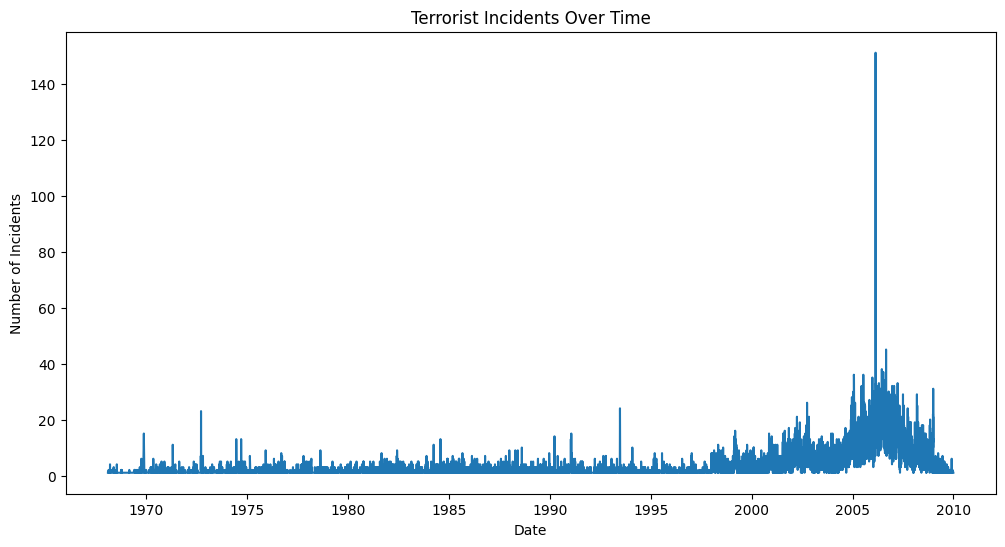

In [126]:
# Convert the 'Date' column to datetime format
df['Date'] = pd.to_datetime(df['Date'])

# Group incidents by date and count the number of incidents for each date
incidents_by_date = df.groupby('Date').size()

# Create a time series chart
plt.figure(figsize=(12, 6))
plt.plot(incidents_by_date.index, incidents_by_date.values)
plt.title('Terrorist Incidents Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Incidents')
plt.show()

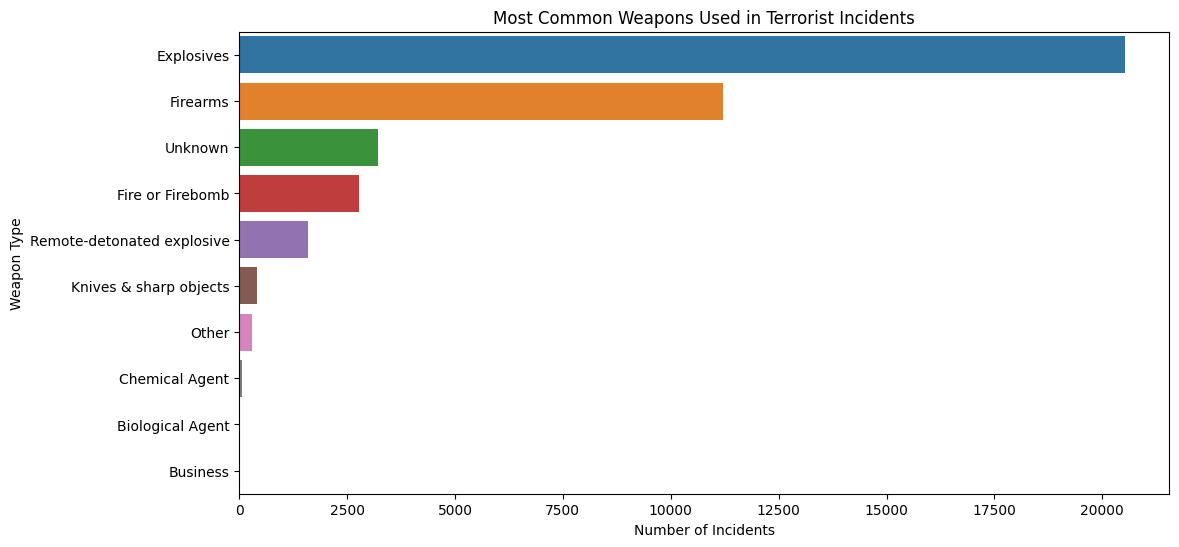

In [127]:
import seaborn as sns

# Group incidents by weapon type and count occurrences
weapons_counts = df['Weapon'].value_counts().head(10)

# Create a bar chart
plt.figure(figsize=(12, 6))
sns.barplot(x=weapons_counts.values, y=weapons_counts.index, orient='h')
plt.title('Most Common Weapons Used in Terrorist Incidents')
plt.xlabel('Number of Incidents')
plt.ylabel('Weapon Type')
plt.show()


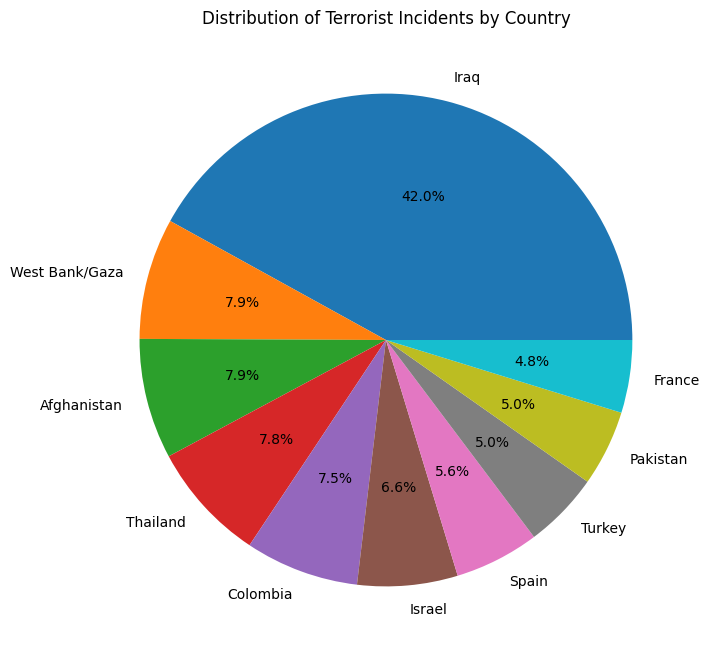

In [128]:
# Group incidents by country and count occurrences
country_counts = df['Country'].value_counts().head(10)

# Create a pie chart
plt.figure(figsize=(8, 8))
plt.pie(country_counts, labels=country_counts.index, autopct='%1.1f%%')
plt.title('Distribution of Terrorist Incidents by Country')
plt.show()


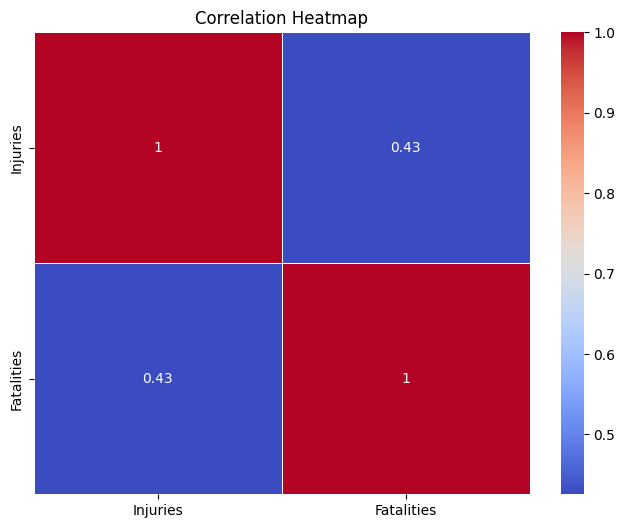

In [129]:
# Assuming you have additional columns for injuries, fatalities, and weapon types
correlation_matrix = df[['Injuries', 'Fatalities']].corr()

# Create a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()


## **6. TOPIC MODELING**

### **Latent Dirichlet Allocation (LDA):-**
Topic modeling is a powerful technique to uncover hidden topics or themes in a large collection of text data. It can help identify common themes in the text data and understand how these themes relate to sentiment. Two commonly used topic modeling techniques are Latent Dirichlet Allocation (LDA) and Non-Negative Matrix Factorization (NMF). Here, I'll provide a high-level overview of how to perform topic modeling and combine it with sentiment analysis


In [130]:
import gensim
from gensim import corpora
from gensim.models import LdaModel
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import string

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


**Text Preprocessing:-** Begin by cleaning and preprocessing your text data. This includes steps like tokenization, stop word removal, and lemmatization.

In [131]:
# Tokenize and preprocess the text data
def preprocess_text(text):
    # Tokenize the text
    tokens = word_tokenize(text.lower())

    # Remove punctuation and stop words
    tokens = [word for word in tokens if word not in string.punctuation]
    tokens = [word for word in tokens if word not in stopwords.words('english')]

    return tokens

**Document-Term Matrix (DTM):-** Create a document-term matrix, where each row represents a document (text description) and each column represents a unique term (word) in the corpus. Tools like TF-IDF or CountVectorizer can be used for this purpose.

In [132]:
# Apply preprocessing to the data
preprocessed_df = [preprocess_text(text) for text in df]

# Create a dictionary from the preprocessed data
dictionary = corpora.Dictionary(preprocessed_df)

# Create a document-term matrix (DTM)
dtm = [dictionary.doc2bow(text) for text in preprocessed_df]

**LDA Model:-** Apply the LDA model to the DTM to identify topics in the text data. You can use libraries like Gensim or scikit-learn for this step. Specify the number of topics you want to extract from the data.

In [133]:
# Build the LDA model
lda_model = LdaModel(dtm, num_topics=3, id2word=dictionary, passes=10)

# Print the topics and their top words
for topic_id, topic_words in lda_model.print_topics():
    print(f"Topic {topic_id + 1}: {topic_words}\n")

# Assign topics to documents
topics_per_document = [lda_model.get_document_topics(doc) for doc in dtm]
print(topics_per_document)

Topic 1: 0.250*"latitude" + 0.142*"description" + 0.142*"weapon" + 0.142*"date" + 0.142*"perpetrator" + 0.036*"longitude" + 0.036*"city" + 0.036*"country" + 0.036*"injuries" + 0.036*"fatalities"

Topic 2: 0.247*"fatalities" + 0.247*"injuries" + 0.063*"latitude" + 0.063*"longitude" + 0.063*"perpetrator" + 0.063*"date" + 0.063*"weapon" + 0.063*"description" + 0.063*"country" + 0.063*"city"

Topic 3: 0.317*"longitude" + 0.181*"country" + 0.181*"city" + 0.046*"latitude" + 0.046*"perpetrator" + 0.046*"date" + 0.046*"weapon" + 0.046*"description" + 0.046*"injuries" + 0.046*"fatalities"

[[(0, 0.66237223), (1, 0.16920617), (2, 0.16842163)], [(0, 0.16769375), (1, 0.16859041), (2, 0.66371584)], [(0, 0.66467065), (1, 0.16784185), (2, 0.16748746)], [(0, 0.1671484), (1, 0.1675794), (2, 0.66527224)], [(0, 0.16769323), (1, 0.16859569), (2, 0.6637111)], [(0, 0.6623289), (1, 0.1692379), (2, 0.1684332)], [(0, 0.6623898), (1, 0.16919702), (2, 0.16841316)], [(0, 0.1673913), (1, 0.664993), (2, 0.16761576)

**Topic Interpretation:-** Once the LDA model is trained, you can examine the top words associated with each topic. This helps in interpreting and labeling the topics.

### **Non-Negative Matrix Factorization (NMF):-**

Non-Negative Matrix Factorization (NMF) is a dimensionality reduction technique commonly used in natural language processing and topic modeling. It factorizes a given matrix into two non-negative matrices, which, when multiplied, approximate the original matrix. NMF is particularly useful for discovering hidden patterns or topics within textual data.


**Text Preprocessing:** Similar to LDA, begin with text preprocessing, including cleaning and creating a document-term matrix.

In [134]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF

**NMF Model:-** Apply the NMF model to the DTM. Specify the number of topics you want to extract.

In [135]:
print(df.columns)

Index(['Date', 'City', 'latitude', 'longitude', 'Country', 'Perpetrator',
       'Weapon', 'Injuries', 'Fatalities', 'Description', 'Latitude',
       'Longitude'],
      dtype='object')


In [136]:
print(df.head())

        Date              City      latitude     longitude  \
0 1968-02-09      Buenos Aires  -34.6131500°  -34.6131500°   
1 1968-02-12     Santo Domingo    18.4861° N    69.9312° W   
2 1968-02-13        Montevideo   -34.9011° S   -56.1645° W   
3 1968-02-20          Santiago   -33.4489° S   -70.6693° W   
4 1968-02-21  Washington, D.C.    38.9072° N    77.0369° W   

              Country Perpetrator            Weapon  Injuries  Fatalities  \
0           Argentina     Unknown          Firearms         0           0   
1  Dominican Republic     Unknown        Explosives         0           0   
2             Uruguay     Unknown  Fire or Firebomb         0           0   
3               Chile     Unknown        Explosives         0           0   
4       United States     Unknown        Explosives         0           0   

                                         Description  Latitude  Longitude  
0  ARGENTINA.  The second floor of the U.S. embas... -34.61315  -34.61315  
1  DOMINICAN

In [137]:
# Remove rows with missing descriptions
df = df.dropna(subset=['Description'])

# Define the number of topics
num_topics = 5  # Adjust this as needed

# Create a TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, stop_words='english')
tfidf = tfidf_vectorizer.fit_transform(df['Description'])  # Use your 'Description' column

**Topic Interpretation:-** After training the NMF model, inspect the top terms associated with each topic to understand and label the topics.

In [138]:
# Create the NMF model
nmf_model = NMF(n_components=num_topics, random_state=1)
nmf_model.fit(tfidf)

# Print the top words for each topic
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        message = f"Topic #{topic_idx + 1}: "
        message += " ".join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)

n_top_words = 10  # Adjust this for the number of top words you want to display
tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()
print_top_words(nmf_model, tfidf_feature_names, n_top_words)

Topic #1: police patrol iraq frequent wounding attacks killing roadside baghdad near
Topic #2: thailand insurgents drive islamic shootings insurgency 2004 educators arson underway
Topic #3: bomb attack exploded device injured people car explosive detonated blast
Topic #4: gunmen killed iraq attacks frequent baghdad shot al opened attack
Topic #5: fired settlement reported claimed gaza rockets hamas israeli wing rocket


## **7. IDENTIFY RADICALIZATION TREND ANALYSIS**

Identifying radicalization trends is a critical aspect of monitoring and countering extremist activities. This process involves analyzing various sources of data, including social media, online forums, and other digital platforms, to detect signs of radicalization and extremism.

## **8. ENTITY RECOGNITION ANALYSIS**

Entity recognition is a vital component of text analysis that involves identifying and categorizing named entities within a text, such as people, organizations, locations, dates, and more. In the context of identifying radicalization trends, entity recognition can be a powerful tool for tracking the influence of specific individuals, organizations, or locations associated with extremist activities.

In [139]:
import spacy

# Load the pre-trained English model
nlp = spacy.load("en_core_web_sm")

In [140]:
# Sample text (replace this with your extremist content)
text = """
In a recent video, Abu Bakr al-Baghdadi, the leader of ISIS, called for more attacks
in the Middle East. The video was released on July 15, 2023.
"""

# Process the text using spaCy
doc = nlp(text)

# Iterate through recognized entities and print their text and label
for ent in doc.ents:
    print(f"Entity: {ent.text}, Label: {ent.label_}")

Entity: Abu Bakr al-Baghdadi, Label: PERSON
Entity: ISIS, Label: ORG
Entity: the Middle East, Label: LOC
Entity: July 15, 2023, Label: DATE


## **9. NETWORK ANALYSIS**

Network analysis in the context of extremist activities involves studying the connections and interactions between individuals and groups associated with extremist ideologies. To perform network analysis

In [141]:
import networkx as nx

In [142]:
# Create an empty graph
G = nx.Graph()

# Add nodes (e.g., individuals or groups)
for entity in df['Perpetrator'].unique():
    G.add_node(entity)

# Add edges (e.g., connections or associations)
for index, row in df.iterrows():
    G.add_edge(row['Perpetrator'], row['City'])

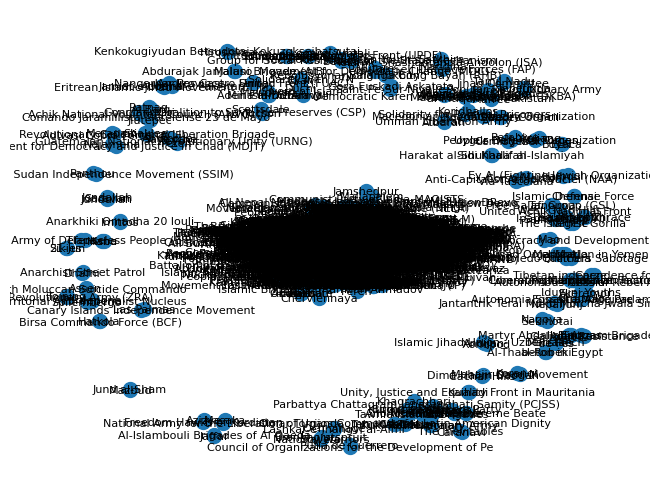

{'Unknown': 0.5967221923696937, 'Other': 0.06636217087587319, 'National Liberation Army of Colombia (ELN)': 0.01047823750671682, 'Frente de Liberacion Nacional del Vietnam del Sur': 0.00013433637829124128, 'al-Fatah': 0.013433637829124127, 'Anti-Castro Cubans': 0.005104782375067169, 'Popular Front for the Liberation of Palestine (PFL': 0.008060182697474477, 'Rebel Armed Forces of Guatemala (FAR)': 0.00026867275658248256, "Al-Sa'iqa": 0.0006716818914562064, 'Movimiento Peronista': 0.00013433637829124128, 'Popular Revolutionary Vanguard (VPR)': 0.00013433637829124128, 'Black Panthers': 0.0005373455131649651, 'Eritrean Liberation Front (ELF)': 0.0013433637829124128, 'Tupamaros (Uruguay)': 0.0004030091348737238, 'Revolutionary Movement of the 8th (MR-8)': 0.00013433637829124128, 'Fuerzas Armadas Peronistas (FAP)': 0.0004030091348737238, 'Peronist Armed Forces (FAP)': 0.00026867275658248256, 'Palestinian Popular Struggle Front': 0.0004030091348737238, 'VAR-Palmares': 0.00013433637829124128,

In [143]:
# Visualize the network (requires Matplotlib)
import matplotlib.pyplot as plt
nx.draw(G, with_labels=True, node_size=100, font_size=8)
plt.show()

# Perform network analysis using NetworkX functions
# Example: Calculate degree centrality
degree_centrality = nx.degree_centrality(G)
print(degree_centrality)

## **10. TEMPORAL ANALYSIS**


Temporal analysis is the process of studying how content and sentiment change over time. It involves examining data with timestamps, like text data with dates, to identify trends, patterns, or shifts in topics and sentiments over different time periods. This analysis helps track evolving radicalization trends or sentiment changes in a dataset.

In [144]:
from textblob import TextBlob

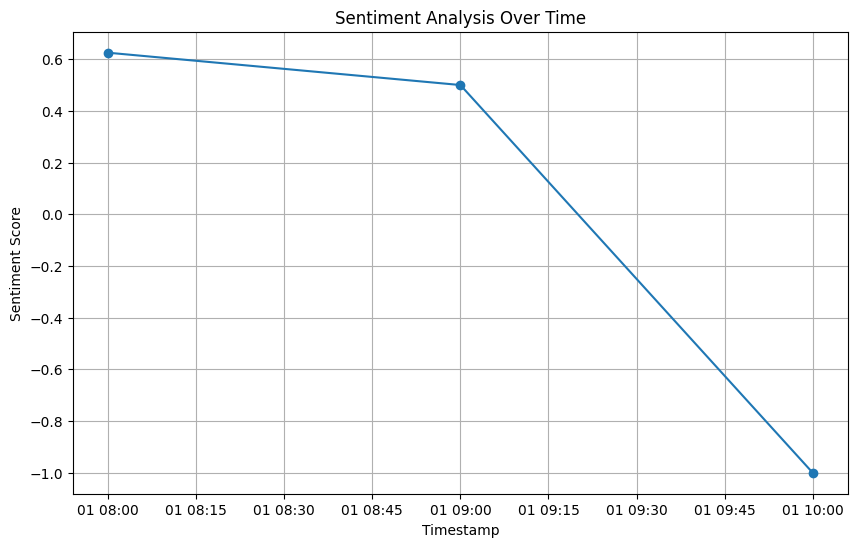

In [145]:
# Sentiment Analysis Over Time

import pandas as pd
from textblob import TextBlob
import matplotlib.pyplot as plt

# Sample dataset with a 'Timestamp' and 'Text' column
data = {
    'Timestamp': ['2023-01-01 08:00:00', '2023-01-01 09:00:00', '2023-01-01 10:00:00'],
    'Text': ['I love this product!', 'This is okay.', 'Terrible experience!']
}

# Create a DataFrame from the sample data
df = pd.DataFrame(data)

# Convert the 'Timestamp' column to datetime
df['Timestamp'] = pd.to_datetime(df['Timestamp'])

# Perform sentiment analysis and store the sentiment scores in a new column
df['Sentiment'] = df['Text'].apply(lambda x: TextBlob(x).sentiment.polarity)

# Plot sentiment over time
plt.figure(figsize=(10, 6))
plt.plot(df['Timestamp'], df['Sentiment'], marker='o')
plt.title('Sentiment Analysis Over Time')
plt.xlabel('Timestamp')
plt.ylabel('Sentiment Score')
plt.grid(True)
plt.show()



### **11. TIME SERIES ANALYSIS**

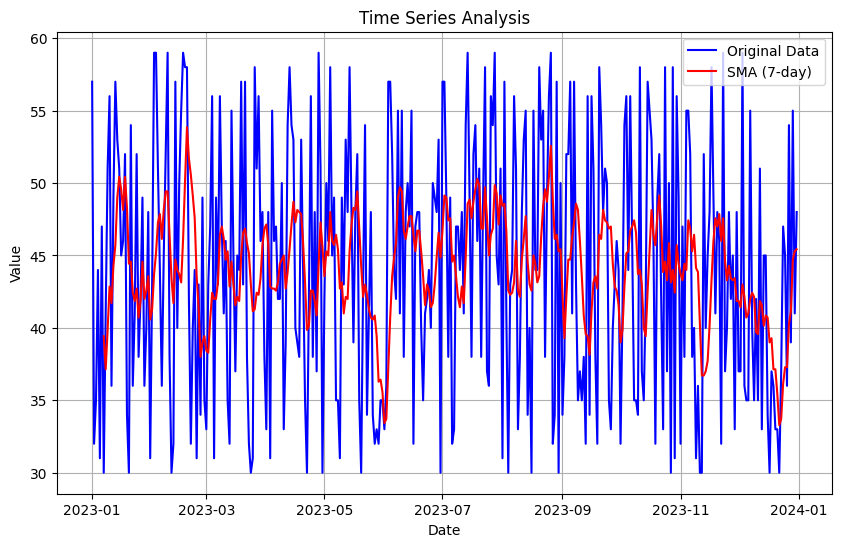

In [146]:
# Sample time series data (replace with your own data)
date_range = pd.date_range(start='2023-01-01', periods=365, freq='D')
values = np.random.randint(30, 60, len(date_range))  # Example values

# Create a DataFrame from the data
data = {'Date': date_range, 'Value': values}
df = pd.DataFrame(data)

# Set 'Date' column as the index
df.set_index('Date', inplace=True)

# Plot the time series data
plt.figure(figsize=(10, 6))
plt.plot(df.index, df['Value'], label='Original Data', color='blue')

# Calculate and plot a simple moving average (SMA)
window_size = 7  # Adjust the window size as needed
sma = df['Value'].rolling(window=window_size).mean()
plt.plot(df.index, sma, label=f'SMA ({window_size}-day)', color='red')

plt.title('Time Series Analysis')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

### **12. MACHINE LEARNING**

In [147]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

In [170]:
df = pd.read_csv("GTD RAND.csv", encoding="ISO-8859-1")

In [152]:
# Define features (predictors) and the target variable
X = df[['City', 'latitude', 'longitude', 'Country', 'Perpetrator', 'Weapon', 'Injuries', 'Fatalities', 'Description']]
df['FutureAttackLabel'] = (df['Injuries'] > 0) | (df['Fatalities'] > 0)
y = df['FutureAttackLabel']

In [153]:
# Convert categorical features to numerical using one-hot encoding
X = pd.get_dummies(X, columns=['City', 'Country', 'Perpetrator', 'Weapon'])

In [154]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40129 entries, 0 to 40128
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Date               40129 non-null  object
 1   City               35155 non-null  object
 2   latitude           12473 non-null  object
 3   longitude          12473 non-null  object
 4   Country            40129 non-null  object
 5   Perpetrator        40125 non-null  object
 6   Weapon             40126 non-null  object
 7   Injuries           40129 non-null  int64 
 8   Fatalities         40129 non-null  int64 
 9   Description        40128 non-null  object
 10  FutureAttackLabel  40129 non-null  bool  
dtypes: bool(1), int64(2), object(8)
memory usage: 3.1+ MB


In [155]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [156]:
# Initialize the Random Forest classifier (you can use other classifiers as well)
clf = RandomForestClassifier(n_estimators=100, random_state=42)

In [157]:
# Function to clean latitude and longitude values
def clean_coordinates(coord):
    # Remove non-numeric characters and determine sign
    if 'N' in coord or 'E' in coord:
        return float(coord.replace('° N', '').replace('° E', '').replace('°', ''))
    elif 'S' in coord or 'W' in coord:
        return -float(coord.replace('° S', '').replace('° W', '').replace('°', ''))
    else:
        return float(coord.replace('°', ''))

In [175]:
# Clean and convert the "longitude" and "latitude" columns
def clean_and_convert_coordinates(coord):
    # Ensure the coordinate is a string
    coord = str(coord)

    # Extract numeric parts from the coordinate string
    parts = re.findall(r"[-+]?\d*\.\d+|\d+", coord)

    if len(parts) >= 1:
        value = float(parts[0])

        # Handle directional indicators (N, S, E, W)
        if 'S' in coord or 'W' in coord:
            value = -value

        return value
    else:
        return None  # Return None for invalid coordinates

In [176]:
def clean_coordinates(coord):
    # Use regular expressions to extract numerical values and handle N/S/E/W
    match = re.search(r'([0-9.-]+)°?\s*([NSWE]?)', coord)
    if match:
        value, direction = match.groups()
        value = float(value)
        if direction in ('S', 'W'):
            value = -value
        return value
    return None

In [177]:
# Update Function that clean and convert co-ordinates

df['Latitude'] = df['latitude'].map(clean_and_convert_coordinates)
df['Longitude'] = df['longitude'].map(clean_and_convert_coordinates)

In [172]:
import re

In [185]:
def clean_and_convert(coord_str):
    if not isinstance(coord_str, str):
        return None

    # Remove special characters, spaces, and trim
    cleaned_str = re.sub(r'[°NnSsEeWw\'"]', '', coord_str).strip()

    # Handle degrees, minutes, seconds format (e.g., '-46 °49')
    if '°' in cleaned_str:
        parts = cleaned_str.split()
        if len(parts) == 2:
            degrees = float(parts[0])
            minutes = float(parts[1].strip('\''))
            if 'S' in coord_str or 'W' in coord_str:
                degrees = -degrees
            return degrees - minutes / 60.0

    # Handle decimal format (e.g., '-46.49')
    try:
        return float(cleaned_str)
    except ValueError:
        return None

In [187]:
# Apply the updated conversion function
df['Latitude'] = df['latitude'].apply(clean_and_convert)
df['Longitude'] = df['longitude'].apply(clean_and_convert)

In [188]:
print(df['latitude'].head())
print(df['longitude'].head())

0    -34.6131500°
1      18.4861° N
2     -34.9011° S
3     -33.4489° S
4      38.9072° N
Name: latitude, dtype: object
0    -34.6131500°
1      69.9312° W
2     -56.1645° W
3     -70.6693° W
4      77.0369° W
Name: longitude, dtype: object


In [190]:
# Apply the updated conversion function
df['Latitude'] = df['latitude'].apply(clean_and_convert)
df['Longitude'] = df['longitude'].apply(clean_and_convert)

# Drop rows with missing or invalid coordinates
df = df.dropna(subset=['Latitude', 'Longitude'])

In [193]:
X = df[['Latitude', 'Longitude']]
y = df['FutureAttackLabel']


# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit the model on the training data
clf.fit(X_train, y_train)

KeyError: ignored